# Demo

 This notebook shows the simulation results for the evolution of a simple quantum harmonic Oscillator whose Hamiltonian is $\hat{H} = {\hbar \omega_0} \hat{a}^\dagger \hat{a}$, in a heat environment given by:
 
  $\hat{L_1} = \sqrt{\gamma_e} \hat{a}^\dagger $ (**Energy excitation**), $\hat{L_2} = \sqrt{\gamma_r} \hat{a}$ (**Energy relaxation**) 
  
  Where $\gamma_e$ is the exicitation rate and $\gamma_r$ is the relaxation rate.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import Bloch, basis
import multiprocessing

NUM_CORE = multiprocessing.cpu_count()

In [3]:
# a helper function to construct a set of jump operators using given rates and max energy level of the system
def buildJumpOperators(relaxation_rate, excitation_rate, n_lvl):
    N = np.diag(np.arange(n_lvl)) # the Number operator
    a = np.sqrt(np.roll(N, -1, axis=0)) # annihilation operator
    a_dagger = a.conj().T   # creation operator
    L_1 = np.sqrt(relaxation_rate) * a
    L_2 = np.sqrt(excitation_rate) * a_dagger 
    return np.stack((L_1, L_2))

    
# # a function to plot the real part of the solution rho(t)
def plotDensityMatrix(times_arr, solutions, legends=[], n=2):
    fig, axs = plt.subplots(n, n, figsize=(10, 8))
    axs = axs.flatten()

    for i in range(n**2):
        for j, xy in enumerate(zip(times_arr, solutions)):
            ts, sol = xy
            if legends and i==0:
                axs[i].plot(ts, np.real(sol[i]), label=legends[j])
                axs[i].legend()
            else:
                axs[i].plot(ts, np.real(sol[i]), label="")

        axs[i].set_title(f'Rho_{i // n}{i % n} v.s. Time')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


# a function to plot a 2-level state vector and its trajectory on the Bloch sphere
def plotBlochSphere(psi, sol):
    # extract the Bloch vector components from the solution vector
    Vx = sol[1] + sol[2]
    Vy = -1j * (sol[2] - sol[1])
    Vz = 2 * sol[0] - 1

    sphere = Bloch()
    sphere.add_points([Vx, Vy, Vz], meth="l")
    sphere.add_states(basis(2, 0) * psi[0] + basis(2, 1) * psi[1])
    sphere.show()

### example 1. Two-level QHO

The following plots the simulated time evolution of the density matrix elements of a 2-level initial state $|\psi\rangle = \frac{1}{\sqrt2}( |0\rangle + |1\rangle)$, for 500 trajectories. The state starts out with equal probability of being in the ground state and the first excited state. 

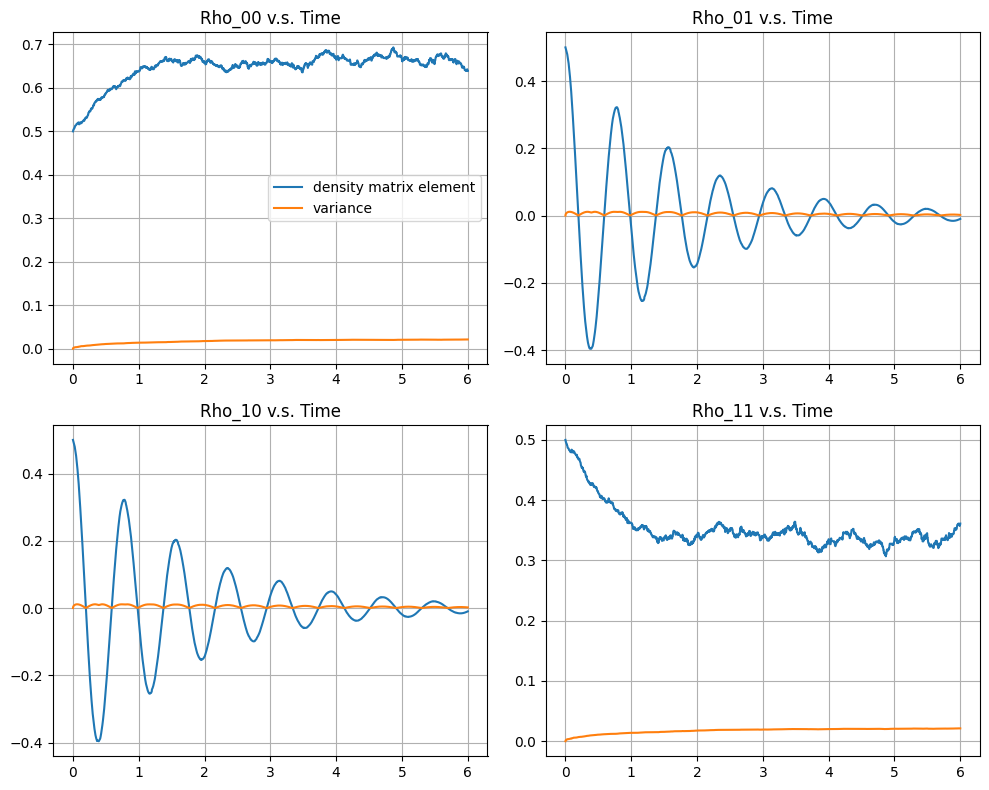

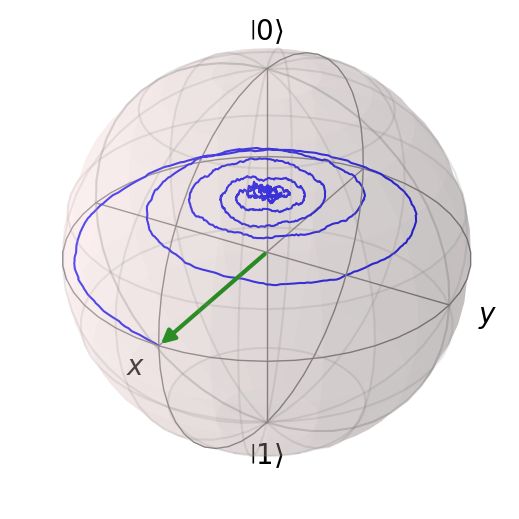

In [7]:
from QJMC import qjmc

N_energy_lvls = 2

omega = 8
hbar = 1
H = (hbar * omega) * np.diag(np.arange(N_energy_lvls))
relaxation_rate = omega/10
excitation_rate = omega/20
Ls = buildJumpOperators(relaxation_rate, excitation_rate, N_energy_lvls)

psi = 1/np.sqrt(N_energy_lvls) * np.ones(N_energy_lvls)
psi /= np.linalg.norm(psi)  # make sure the state vector is normalized
t0, tf = 0, 6
num_trajectories = 500
dt = 0.003

ts, traj_avg, variance = qjmc(H, Ls, t0, tf, psi, dt=dt, n_traj=num_trajectories, use_multicore=True, n_cores=NUM_CORE)
legends = ["density matrix element", "variance"]
plotDensityMatrix([ts, ts], [traj_avg, variance], legends, n=N_energy_lvls)
plotBlochSphere(psi, traj_avg)

### example 2. Five-level QHO, 500 trajectories

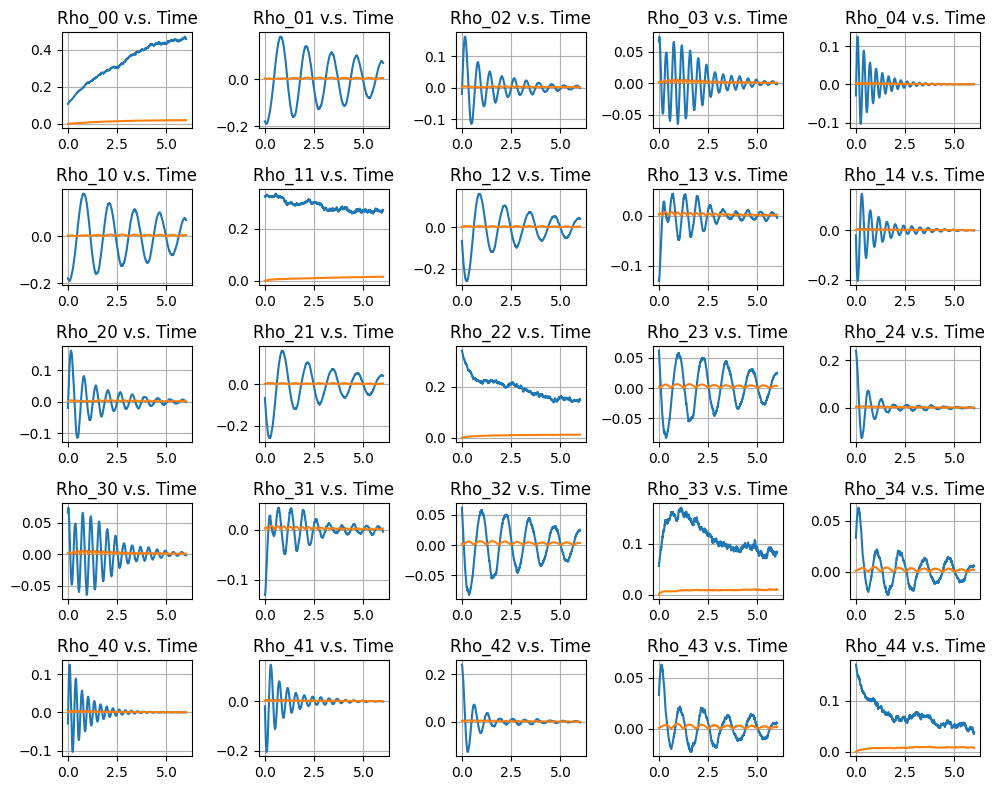

In [8]:
# simluates a 5-level QHO with QJMC
N_energy_lvls = 5
omega = 5
hbar = 1
H = (hbar * omega) * np.diag(np.arange(N_energy_lvls))
relaxation_rate = omega/10
excitation_rate = omega/20
Ls = buildJumpOperators(relaxation_rate, excitation_rate, N_energy_lvls)

# create random initial state
psi = np.random.uniform(-1, 1, N_energy_lvls) + 1j*np.random.uniform(-1, 1, N_energy_lvls)
psi /= np.linalg.norm(psi)  # make sure the state vector is normalized
trajs = []
num_trajectories = 500

ts, traj_avg, variance = qjmc(H, Ls, t0, tf, psi, dt=dt, n_traj=num_trajectories, use_multicore=True, n_cores=NUM_CORE)
plotDensityMatrix([ts, ts], [traj_avg, variance], n=N_energy_lvls)